In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.geometry import LineString
from shapely.ops import polygonize
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import cascaded_union

PATH = 'cb_2018_us_county_within_cd116_500k.shx'

z_pd = pd.read_csv('./Geocodes_USA_with_Counties.csv') # https://data.healthcare.gov/dataset/Geocodes-USA-with-Counties/52wv-g36k
usa = gpd.read_file(PATH)


In [2]:
z_pd = z_pd[~z_pd['state'].isin([
    'AK', 'PR', 'VI', 'AE', 'AP', 'DE', 'HI',
    'AA', 'AS', 'GU', 'PW', 'FM', 'MP', 'MH'
])].drop(['world_region', 'notes'], axis=1)

In [3]:
z_pd['geometry'] = [ Point(f) for f in z_pd[['longitude', 'latitude']].values ]

In [4]:
# need to map the coasts to the voronoi edges
# to determine the coast of the unites states, we can do an edge traversal
usa_df = usa.join(usa['geometry'].bounds)

# continental bound
westernmost = -124.733 # longitude
easternmost = -66.95 # longitude
northernmost = 49.3833  # latitude
southernmost = 25.1166 # latitude

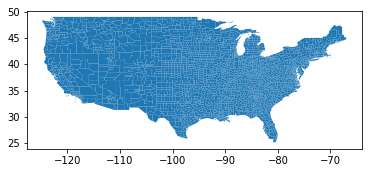

In [5]:
# just get the counties in the continental us
top = usa_df['maxy'] < northernmost # north 
bottom = usa_df['miny'] > southernmost # south
cusa_df = usa_df[top & bottom]
cusa_df.plot()

In [6]:
z_gdf = gpd.GeoDataFrame(z_pd, geometry='geometry')


In [7]:
z2_gdf = gpd.sjoin(z_gdf, cusa_df, op='within', how='right')


In [8]:
z2_gdf = z2_gdf.drop('index_left', axis=1)

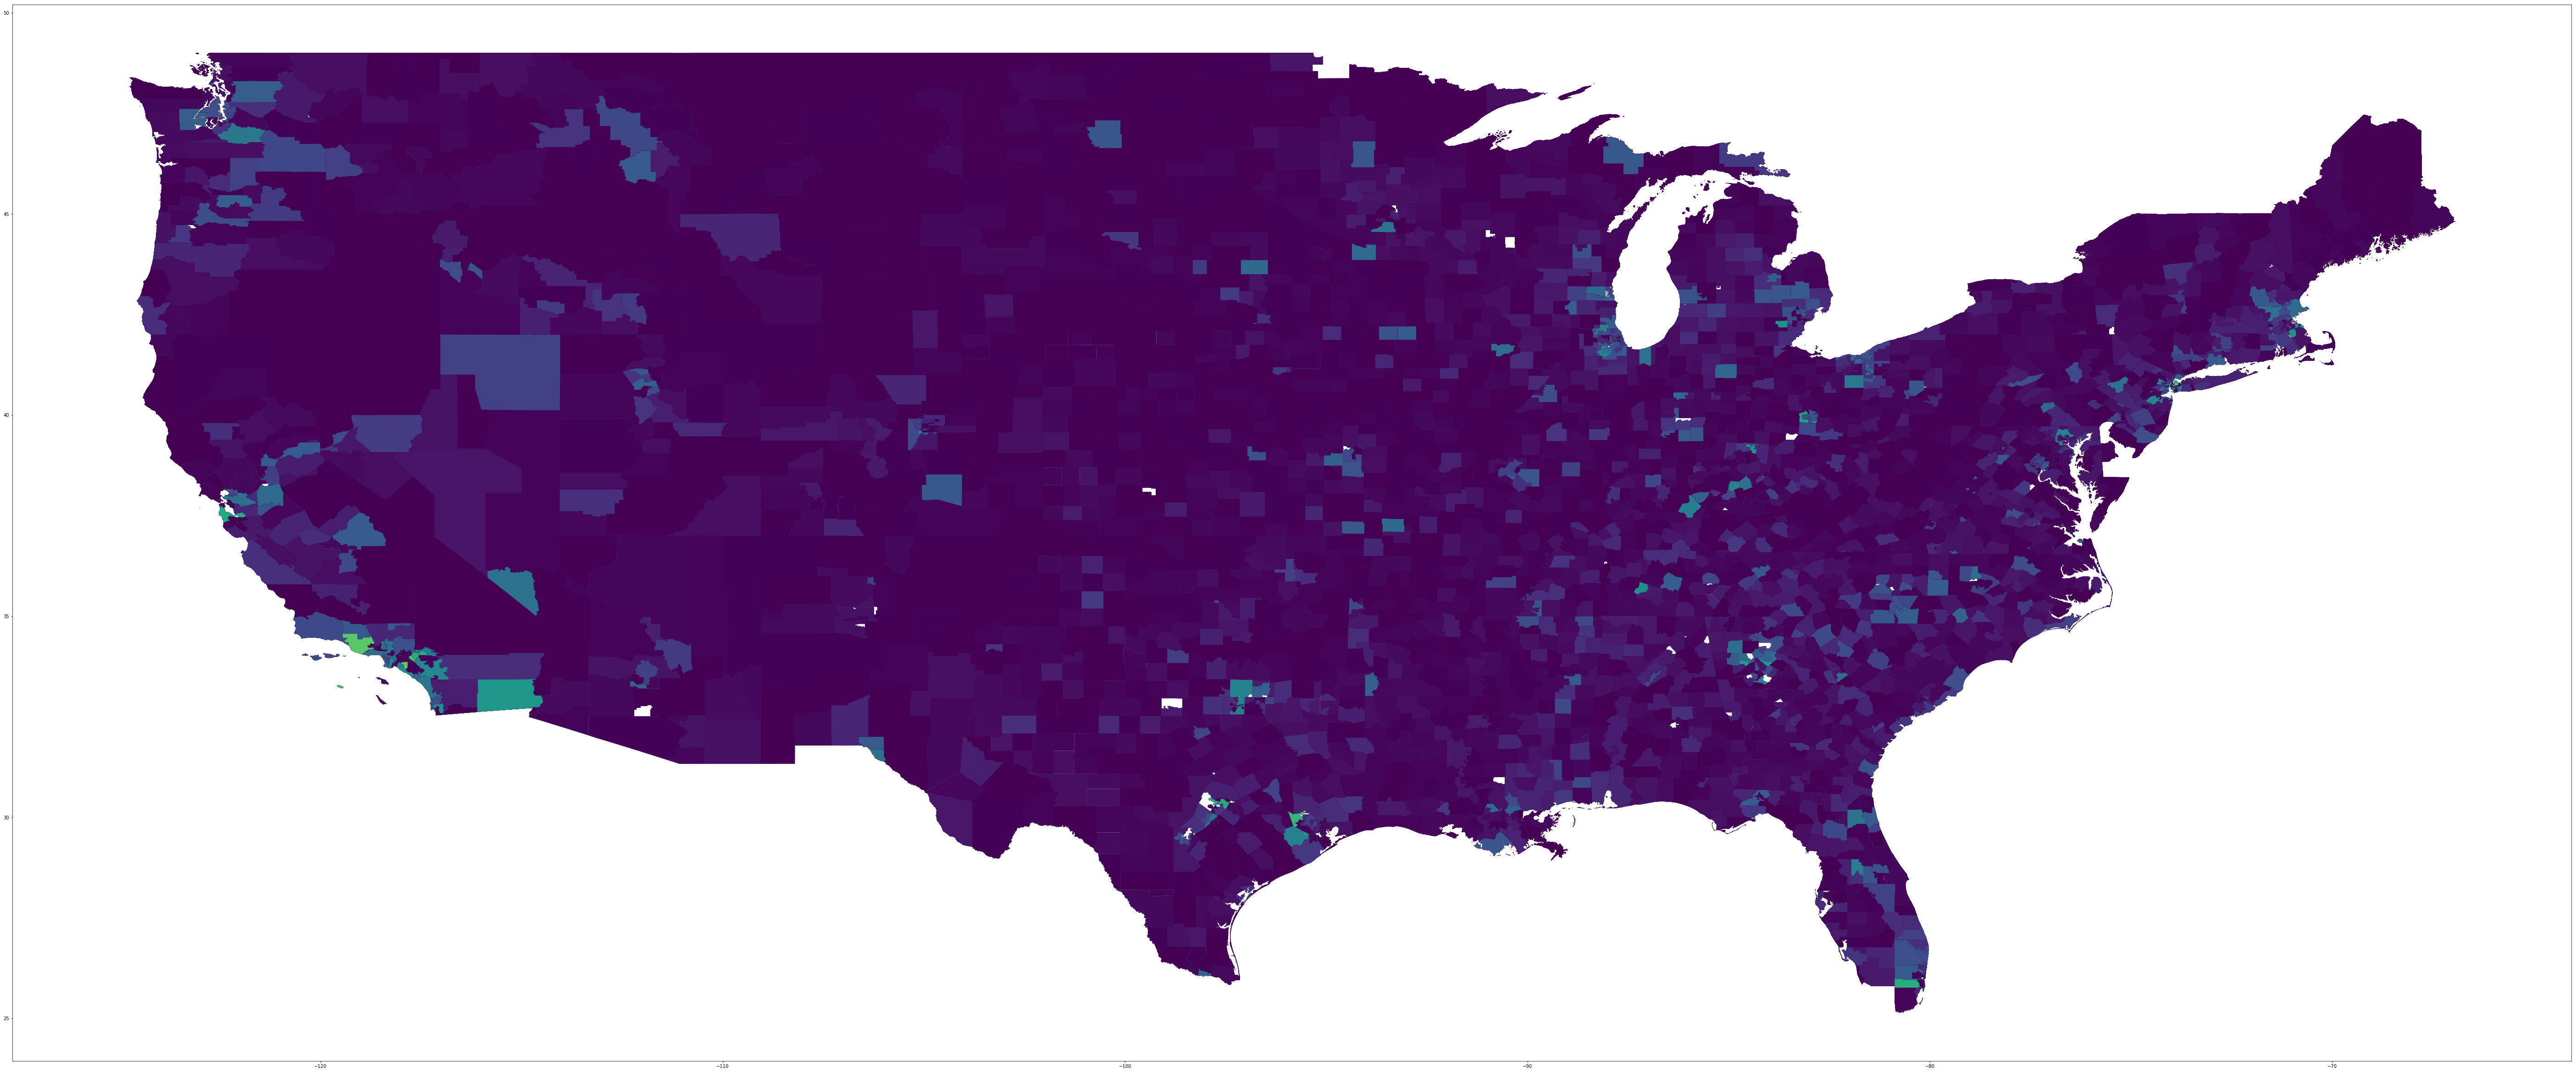

In [9]:
f, ax = plt.subplots(1, figsize=(100,100))

ax = z2_gdf.plot(column='estimated_population', ax = ax)
plt.show()


In [10]:
sum(z2_gdf['estimated_population'].dropna())

236948293.0

## Make points

In [11]:
r = 1
width = int(r * 2680)
height = int(r * 1582)

latitudes = np.linspace(westernmost, easternmost, width)
longitudes = np.linspace(southernmost, northernmost, height)

longs, lats = np.meshgrid(longitudes, latitudes)

In [12]:
dots = [Point((lats[j,i], longs[j,i])) for i in range(height) for j in range(width)]

In [13]:
dots_gdf = gpd.GeoDataFrame(pd.DataFrame(dots, columns=['dots']), geometry='dots')

In [14]:
len(dots_gdf)

4239760

In [ ]:
z3_gdf = gpd.sjoin(z2_gdf, dots_gdf, how='right', op='contains').dropna(subset=['zip']).drop('index_left', axis=1)

In [ ]:
z3_gdf.head()

In [ ]:
len(z3_gdf)

I use the dot count to divide the population amongst each dot.

In [ ]:
z_dot_counts = {}
for z in z3_gdf['zip'].unique():
    z_dot_counts[z] = sum(z3_gdf['zip'] == z)

In [ ]:
dots_pd = pd.DataFrame([z_dot_counts.keys(), z_dot_counts.values()]).transpose()
dots_pd.columns = ['zip', 'dots']


In [ ]:
z4_gdf = z2_gdf.merge(dots_pd)
z4_gdf['area'] = z4_gdf['geometry'].area
z4_gdf.sort_values(['dots', 'area'], ascending=False).head()


In [ ]:
# now, each point gets the pop_per_point
z5_gdf = gpd.sjoin(z4_gdf, dots_gdf, how='right', op='contains').dropna(subset=['zip'])

In [ ]:
z5_gdf['dots_per_pop'] = z5_gdf['estimated_population'].divide(z5_gdf['dots_x'])

In [ ]:
z5_gdf.head()

In [ ]:
z6 = gpd.GeoDataFrame(z5_gdf, geometry='dots_y')

In [ ]:
z6.plot(column='dots_per_pop')

#### Now pull in the hospital stuff

In [ ]:
hospital = pd.read_csv('./Hospitals.csv')


# what is the key info for the hospital dataset? Just the coordinates and the number of beds.
hospital_cols = [
    'X', 'Y', 'ID', 'NAME', 'ADDRESS', 
    'CITY', 'STATE', 'ZIP', 'TYPE', 
    'POPULATION', 'COUNTY', 
    'LATITUDE', 'LONGITUDE',
    'WEBSITE',
    'TTL_STAFF', 'BEDS', 'TRAUMA', 'HELIPAD'
]

# filter out the hospitals that aren't open and don't have bed data
h_df = hospital[hospital_cols][(hospital['STATUS'] != 'CLOSED').multiply(hospital['BEDS'] != -999)]

# create the geopandas dataframe
h_points = [Point(xy) for xy in zip(h_df['LONGITUDE'], h_df['LATITUDE'])]
h_gdf = gpd.GeoDataFrame(h_df, geometry = h_points)

# create the voronoi diagram for hospitals
h_points = h_gdf[['LONGITUDE', 'LATITUDE']].values
h_vor = Voronoi(h_points)


# associate the voronoi polygons with each hospital
h_lines = [
    LineString(h_vor.vertices[line])
    for line in h_vor.ridge_vertices
    if -1 not in line
]

h_polygons = [p for p in polygonize(h_lines)]

h_polygons_gdf = gpd.GeoDataFrame(h_polygons, columns = ['polygon'])
h_polygons_gdf.geometry = h_polygons_gdf['polygon']

# merge in the polygons
h2_gdf = gpd.sjoin(h_gdf, h_polygons_gdf, how='left', op='within')

# set the geometry of the gdf to be the polygon instead of the point
h2_gdf.geometry = h2_gdf['polygon']
h2_gdf = h2_gdf.drop('index_right', axis=1) # technical, need to remove col with this name
h2_gdf = h2_gdf.dropna(subset=['polygon'])


In [ ]:
# get all the points in a polygon
z7 = gpd.sjoin(h2_gdf, z6.drop('index_left', axis=1), op='contains', how='right')

In [ ]:
len(z7)

In [ ]:
region_counts = {}
for _id in z7['ID'].unique():
    region_counts[_id] = sum(z7[z7['ID'] == _id]['pop_per_dot'])

In [ ]:
region_counts_df = pd.DataFrame([region_counts.keys(), region_counts.values()]).transpose()
region_counts_df.columns = ['ID', 'total_people']


In [ ]:
h3_gdf = h2_gdf.merge(region_counts_df, on='ID', how='outer')

In [ ]:
h3_gdf

In [ ]:
sum(h3_gdf['total_people'].dropna())